# Mie Resonance

**Scott Prahl**

**Feb 2025**

Mie resonance occurs when light interacts with a particle, typically a sphere, and the scattered field exhibits enhanced response at specific wavelengths due to constructive interference of multipole modes. These resonances are determined by Mie coefficients, which describe the scattering efficiency of electric and magnetic multipoles (dipoles, quadrupoles, etc.). The resonance wavelengths depend on the particle’s size, refractive index, and the surrounding medium.  Resonances are commonly exploited in photonic devices, sensors, and metamaterials.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import miepython as mie
from miepython.util import cs


def resonant_wavelengths(n_pole, d, m, lambda_range, n_env=1.0):
    """
    Find resonant wavelengths for spheres within the specified wavelength range.

    Parameters:
        n_pole (int): Order of the Mie coefficient to optimize.
        d (float): Diameter of the sphere in microns.
        m (complex): Index of refraction of the sphere.
        lambda_range (tuple): Wavelength range (start, stop) in microns.
        n_env (float, optional): Refractive index of the environment (default 1.0).

    Returns:
        tuple: Resonance wavelengths for a_n and b_n.
    """

    def mie_a_value(lambda_microns):
        lam = lambda_microns / n_env
        x = np.pi * d / lam
        mm = m / n_env
        a, _ = mie.coefficients(mm, x, n_pole)
        return -abs(a[-1])  # Negative for maximization

    def mie_b_value(lambda_microns):
        lam = lambda_microns / n_env
        x = np.pi * d / lam
        mm = m / n_env
        _, b = mie.coefficients(mm, x, n_pole)
        return -abs(b[-1])  # Negative for maximization

    # Minimize resonance conditions
    result_a = minimize_scalar(mie_a_value, bounds=lambda_range, method="bounded")
    result_b = minimize_scalar(mie_b_value, bounds=lambda_range, method="bounded")

    # Check for convergence
    if not result_a.success or not result_b.success:
        raise ValueError("Optimization did not converge. Check the lambda range or input parameters.")

    return result_a.x, result_b.x


%config InlineBackend.figure_format = 'retina'

### Resonances (Conducting Spheres)

The index of refraction m of a material is directly related to the electric permittivity $\varepsilon $ and magnetic permeability $\mu$ of the material. This relationship emerges from how electromagnetic waves propagate through the material.

$$
m = \sqrt{\frac{\mu \varepsilon}{\mu_0 \varepsilon_0}}
$$

The index of refraction is expressed in terms of the relative permittivity $\varepsilon_r$ and relative permeability $\mu_r$ of the material:

$$
   \varepsilon_r = \frac{\varepsilon}{\varepsilon_0}, \quad \mu_r = \frac{\mu}{\mu_0}
$$

Therefore:
$$
m = \sqrt{\varepsilon_r \mu_r}
$$

For most optical materials (e.g., glasses, water), the magnetic permeability is very close to that of free space $\mu_r \approx 1 $. In such cases:
$$
   m \approx \sqrt{\varepsilon_r}
$$

The general idea about resonances that one Mie coefficient may be very large relative to others.  If this value is $a_1$ then the resonance is due to an electric dipole.  If it is $b_1$ then it is a magnetic dipole.  Similarly $a_2$ and $b_2$ correspond to electric and magnetic quadrupoles.  In the graph below it is apparent that the quadrupole resonances are much narrower than the dipole resonances.

/opt/homebrew/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


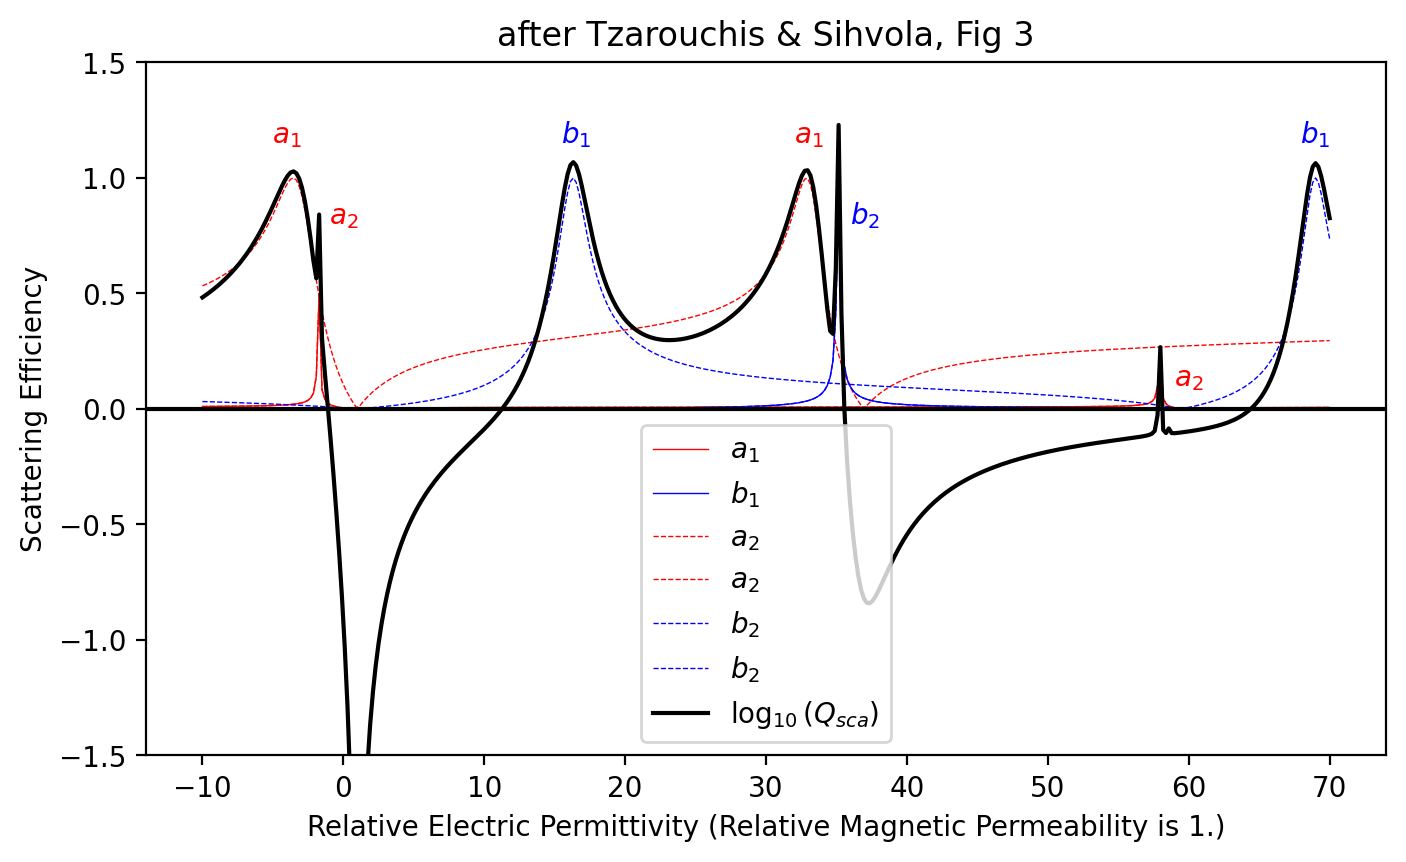

In [2]:
mu = 1
x = 0.75

# avoid epsilon = 0
epsilon = np.linspace(-10, -0.1, 50, dtype=complex)
epsilon = np.append(epsilon, np.linspace(0.1, 70, 350, dtype=complex))
m = np.conjugate(np.sqrt(epsilon * mu)) + 1e-10

plt.figure(figsize=(8, 4.5))
aa, bb = mie.coefficients(m, x, n_pole=2)

a = aa[:, -1]
b = bb[:, -1]

plt.plot(epsilon, abs(a), "r", label=r"$a_1$", lw=0.5)
plt.plot(epsilon, abs(b), "b", label=r"$b_1$", lw=0.5)
plt.text(-4, 1.15, r"$a_1$", color="red", ha="center")
plt.text(33, 1.15, r"$a_1$", color="red", ha="center")
plt.text(16.5, 1.15, r"$b_1$", color="blue", ha="center")
plt.text(69, 1.15, r"$b_1$", color="blue", ha="center")

a, b = mie.coefficients(m, x, n_pole=2)

plt.plot(epsilon, abs(a), "r--", label=r"$a_2$", lw=0.5)
plt.plot(epsilon, abs(b), "b--", label=r"$b_2$", lw=0.5)
plt.text(37, 0.8, r"$b_2$", color="blue", ha="center")
plt.text(0, 0.8, r"$a_2$", color="red", ha="center")
plt.text(60, 0.1, r"$a_2$", color="red", ha="center")

_, qsca, _, _ = mie.efficiencies_mx(m, x)

plt.plot(epsilon, np.log10(qsca + 1e-8), label=r"$\log_{10} (Q_{sca})$", color="black")

plt.axhline(0, color="black")
plt.xlabel("Relative Electric Permittivity (Relative Magnetic Permeability is 1.)")
plt.ylabel("Scattering Efficiency")
plt.title("after Tzarouchis & Sihvola, Fig 3")
plt.legend()
plt.ylim(-1.5, 1.5)
plt.show()

The scattering efficiency of a homogeneous sphere (in logarithmic scale) is plotted below as a function of the permittivity and the size parameter. The yellow regions indicate areas of radiation enhancement, with two distinct regions observed: one corresponding to negative permittivity (plasmonic region) and the other to positive permittivity (dielectric region).

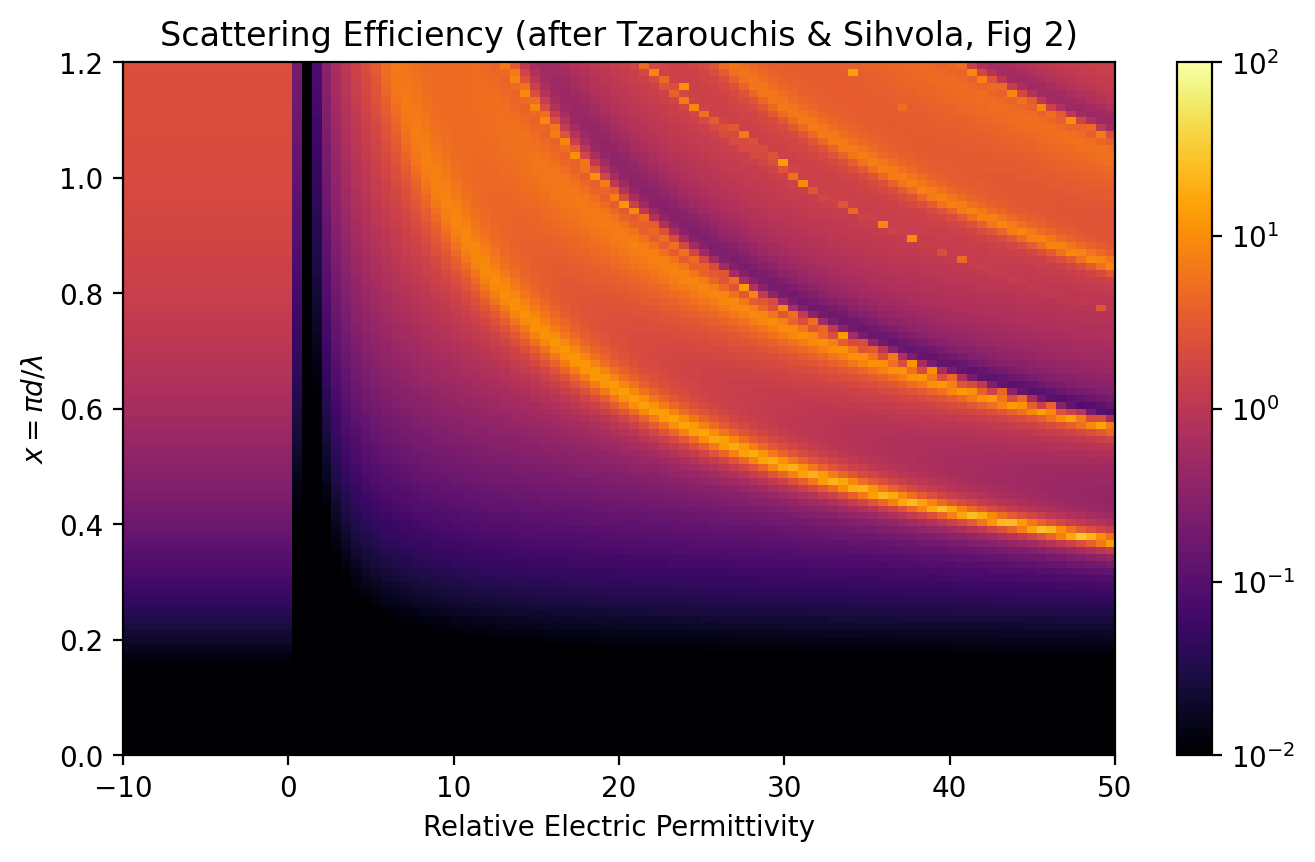

In [3]:
x = np.linspace(0.1, 1.2, 100)
epsilon = np.linspace(-10, 50, 100, dtype=complex)
X, E = np.meshgrid(x, epsilon)

qext = np.zeros_like(X)
qsca = np.zeros_like(X)
qback = np.zeros_like(X)
g = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(E.shape[1]):
        m = np.sqrt(E[i, j])
        qext[i, j], qsca[i, j], qback[i, j], g[i, j] = mie.efficiencies_mx(m, X[i, j])

plt.figure(figsize=(8, 4.5))
im = plt.imshow(
    np.log10(qsca.T),
    extent=(-10, 50, 0, 1.2),
    origin="lower",
    aspect="auto",
    vmin=-2,
    vmax=2,
    cmap="inferno",
)

cbar = plt.colorbar(im, format="$10^{%d}$")  # Custom formatting
cbar.set_ticks([-2, -1, 0, 1, 2])

plt.ylabel(r"$x= \pi d/\lambda$")
plt.xlabel("Relative Electric Permittivity")
plt.title("Scattering Efficiency (after Tzarouchis & Sihvola, Fig 2)")
plt.show()

### Non-absorbing spheres

The scattering of light by a non-absorbing dielectric sphere of diameter $d$ and refractive index $m$ is considered in a uniform environment with index 1. Both the sphere and the medium are assumed to have a magnetic permeability of 1.

The scattered field can be expressed as a multipole expansion, characterized by the electric $a_n$ and magnetic $b_n$ Mie coefficients, where:

* $a_1$ and $b_1$: Electric and magnetic dipoles.
* $a_2$ and $b_2$: Electric and magnetic quadrupoles.
* Higher-order terms correspond to higher multipoles. 

The graphs in this section follows García-Etxarri et al. [Strong magnetic response of submicron silicon particles in the infrared](https://doi.org/10.1364/OE.19.004815)

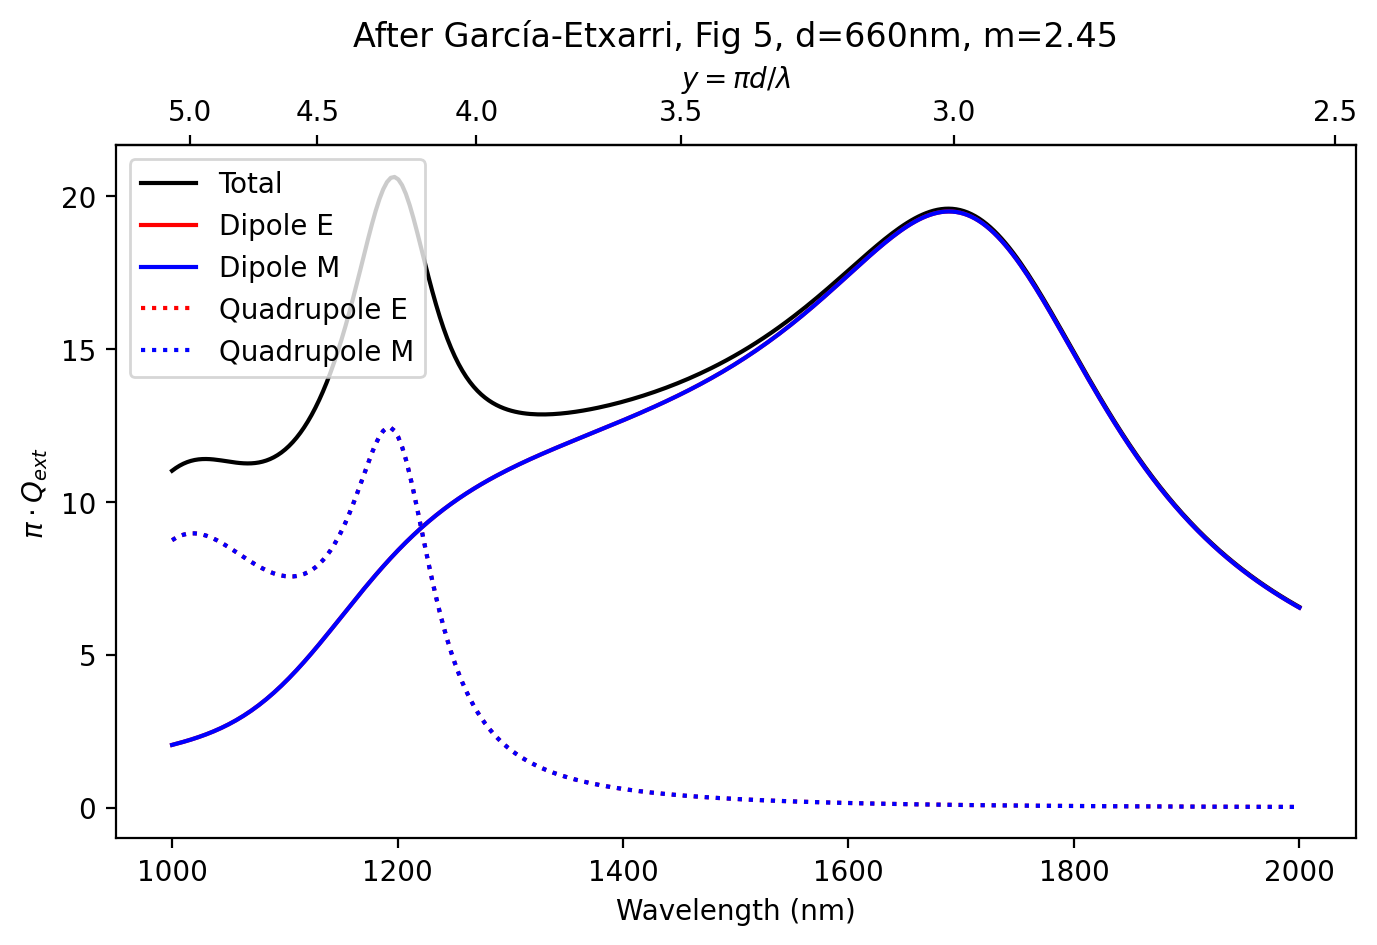

In [4]:
lam = np.linspace(1, 2, 300)

m = 2.45
a = 0.33
d = 2 * a
x = np.pi * d / lam


# needed to plot axis labels on top
def inverse(y):  # top axis values to bottom axis values
    return 1000 * m * np.pi * d / (y + 1e-6)


def forward(lam1000):
    return m * np.pi * d / (lam1000 / 1000)  # bottom values to top values


plt.figure(figsize=(8, 4.5))

# Add secondary x-axis
secax = plt.gca().secondary_xaxis("top", functions=(forward, inverse))
secax.set_xlabel(r"$y=\pi d/\lambda$")  # Label for the top axis

qext, qsca, qback, g = mie.efficiencies_mx(m, x, 0)
plt.plot(lam * 1000, qsca * np.pi, "k", label="Total")

qext, qsca, qback, g = mie.efficiencies_mx(m, x, 1)
plt.plot(lam * 1000, qsca * np.pi, "r", label="Dipole E")

qext, qsca, qback, g = mie.efficiencies_mx(m, x, 1, field="Magnetic")
plt.plot(lam * 1000, qsca * np.pi, "b", label="Dipole M")

qext, qsca, qback, g = mie.efficiencies_mx(m, x, 2)
plt.plot(lam * 1000, qsca * np.pi, "r:", label="Quadrupole E")

qext, qsca, qback, g = mie.efficiencies_mx(m, x, 2, field="Magnetic")
plt.plot(lam * 1000, qsca * np.pi, "b:", label="Quadrupole M")

plt.xlabel("Wavelength (nm)")
plt.ylabel(r"$\pi\cdot Q_{ext}$")
plt.title("After García-Etxarri, Fig 5, d=660nm, m=2.45")

plt.legend()
plt.show()

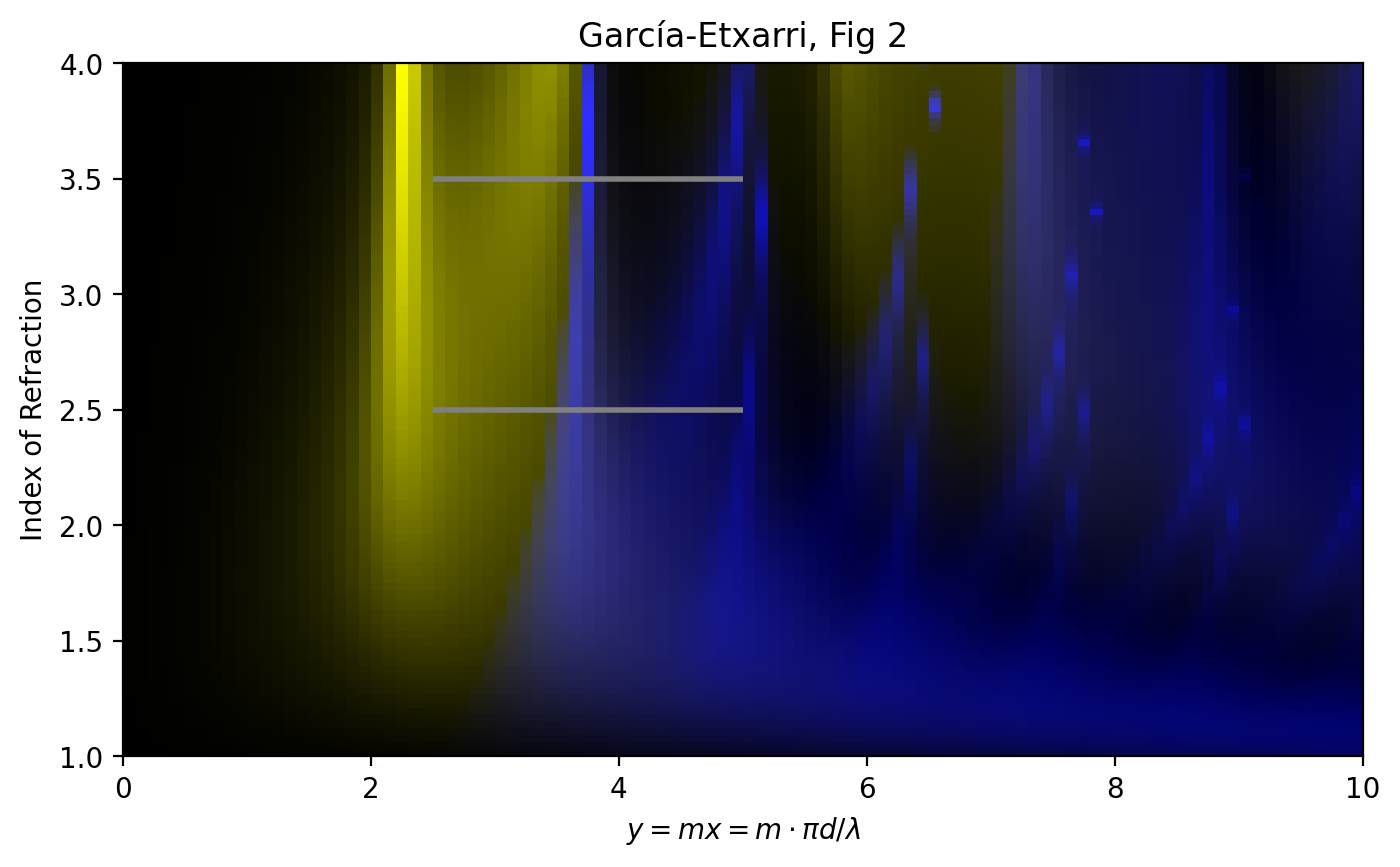

In [5]:
# Color function used by García-Etxarri
def color_function(y, m):
    x = y / m
    qext, _, _, _ = mie.efficiencies_mx(m, x, 0)
    qext_1m, _, _, _ = mie.efficiencies_mx(m, x, 1, field="Magnetic")
    qext_1e, _, _, _ = mie.efficiencies_mx(m, x, 1, field="Electric")
    delta = qext**2 - qext_1m**2 - qext_1e**2
    if delta < 0:
        delta = 0
    qres = np.sqrt(delta)
    r, g, b = qext_1e, qext_1m, qres
    return r, g, b


def normalize_global(array):
    return (array - array.min()) / (array.max() - array.min())


y = np.linspace(1, 10, 100)  # 300 points for y
m = np.linspace(1.2, 4, 100)  # 300 points for m
Y, M = np.meshgrid(y, m)

# Create normalized RGB values for over all Y and M
R = np.zeros_like(Y)
G = np.zeros_like(Y)
B = np.zeros_like(Y)

for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        R[i, j], G[i, j], B[i, j] = color_function(Y[i, j], M[i, j])

R = normalize_global(R)
G = normalize_global(G)
B = normalize_global(B)
RGB = np.stack((R, G, B), axis=-1)  # create an RGB image


plt.figure(figsize=(8, 4.5))
plt.imshow(RGB, extent=(0, 10, 1, 4), origin="lower", aspect="auto")
plt.hlines(2.5, 2.5, 5, colors="gray", lw=2)
plt.hlines(3.5, 2.5, 5, colors="gray", lw=2)

plt.xlabel(r"$y=mx=m\cdot \pi d/\lambda$")
plt.ylabel("Index of Refraction")
plt.title("García-Etxarri, Fig 2")
plt.show()

Here we see that the maximum value $b_1$ and $b_2$ is close to the maximum in the extinction coefficient.

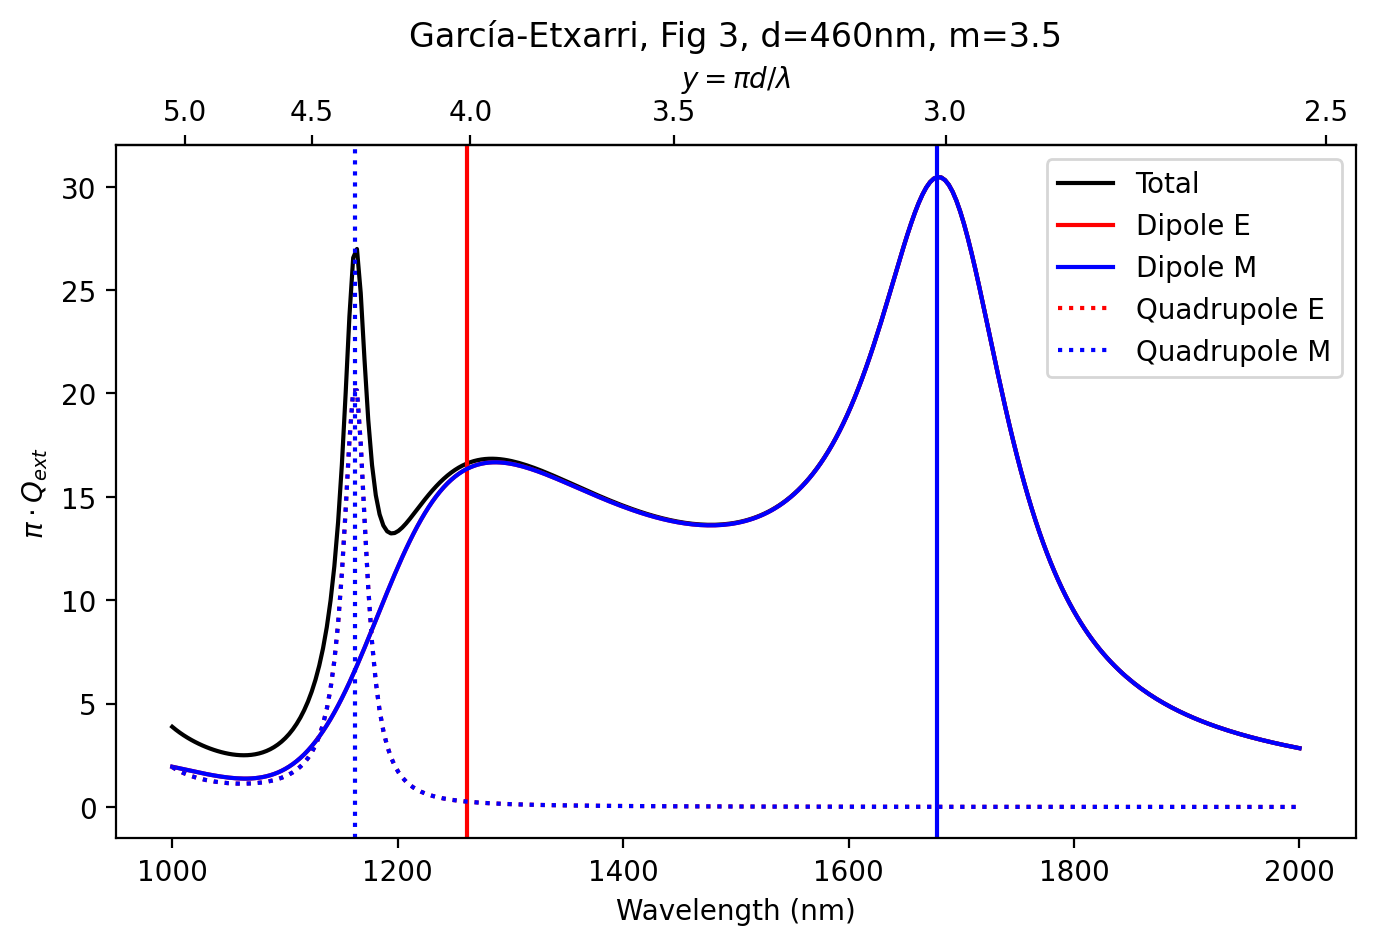

In [6]:
lam = np.linspace(1, 2, 300)

m = 3.5
a = 0.23
d = 2 * a
x = np.pi * d / lam


def inverse(y):  # top to bottom
    return 1000 * m * np.pi * d / (y + 1e-6)


def forward(lam1000):
    return m * np.pi * d / (lam1000 / 1000)  # bottom to top


a1_lambda_max, b1_lambda_max = resonant_wavelengths(1, d, m, (lam[0], lam[-1]))
a2_lambda_max, b2_lambda_max = resonant_wavelengths(2, d, m, (lam[0], lam[-1]))

plt.figure(figsize=(8, 4.5))

# Add secondary x-axis
secax = plt.gca().secondary_xaxis("top", functions=(forward, inverse))
secax.set_xlabel(r"$y=\pi d/\lambda$")  # Label for the top axis

qext, qsca, qback, g = mie.efficiencies_mx(m, x, 0)
plt.plot(lam * 1000, qsca * np.pi, "k", label="Total")

qext, qsca, qback, g = mie.efficiencies_mx(m, x, 1)
plt.plot(lam * 1000, qsca * np.pi, "r", label="Dipole E")
plt.axvline(a1_lambda_max * 1000, color="red")

qext, qsca, qback, g = mie.efficiencies_mx(m, x, 1, field="Magnetic")
plt.plot(lam * 1000, qsca * np.pi, "b", label="Dipole M")
plt.axvline(b1_lambda_max * 1000, color="blue")

qext, qsca, qback, g = mie.efficiencies_mx(m, x, 2)
plt.plot(lam * 1000, qsca * np.pi, "r:", label="Quadrupole E")

qext, qsca, qback, g = mie.efficiencies_mx(m, x, 2, field="Magnetic")
plt.plot(lam * 1000, qsca * np.pi, "b:", label="Quadrupole M")
plt.axvline(b2_lambda_max * 1000, color="blue", ls=":")

plt.xlabel("Wavelength (nm)")
plt.ylabel(r"$\pi\cdot Q_{ext}$")
plt.title("García-Etxarri, Fig 3, d=460nm, m=3.5")
plt.legend()
plt.show()

### Silver nanoparticles

Example from Kelly et al., "The Optical Properties of Metal Nanoparticles: The Influence of Size, Shape, and Dielectric Environment," J. Phys. Chem. B 2003, 107, 668-677

The graph is not quite the same because a different source was used for the index of refraction of silver.

In [7]:
# https://doi.org/10.1103/PhysRevMaterials.3.105201

ag_lambda, ag_n, ag_k = np.array(
    [
        [0.245202, 1.168773, 1.331022],
        [0.246793, 1.176486, 1.342173],
        [0.248384, 1.184909, 1.352390],
        [0.249976, 1.195191, 1.360441],
        [0.251567, 1.208012, 1.365649],
        [0.253159, 1.222298, 1.369346],
        [0.254751, 1.236561, 1.373296],
        [0.256342, 1.250863, 1.377493],
        [0.257934, 1.266081, 1.380957],
        [0.259526, 1.280422, 1.385425],
        [0.261118, 1.295747, 1.388624],
        [0.262710, 1.314122, 1.388161],
        [0.264302, 1.332088, 1.387543],
        [0.265894, 1.349186, 1.387035],
        [0.267486, 1.365779, 1.386098],
        [0.269078, 1.381617, 1.384834],
        [0.270671, 1.397479, 1.382323],
        [0.272263, 1.414073, 1.377756],
        [0.273856, 1.430565, 1.371857],
        [0.275448, 1.446650, 1.364803],
        [0.277041, 1.462390, 1.356414],
        [0.278633, 1.477705, 1.346650],
        [0.280226, 1.493032, 1.335003],
        [0.281819, 1.507621, 1.322091],
        [0.283412, 1.521520, 1.308001],
        [0.285004, 1.534962, 1.292706],
        [0.286597, 1.548117, 1.276244],
        [0.288190, 1.561090, 1.258708],
        [0.289783, 1.573846, 1.240198],
        [0.291377, 1.585484, 1.221170],
        [0.292970, 1.597032, 1.200512],
        [0.294563, 1.609048, 1.177539],
        [0.296156, 1.622041, 1.151580],
        [0.297750, 1.638017, 1.119556],
        [0.299343, 1.652347, 1.081758],
        [0.300936, 1.664638, 1.035518],
        [0.302530, 1.674244, 0.981291],
        [0.304124, 1.676124, 0.924319],
        [0.305717, 1.670761, 0.862526],
        [0.307311, 1.656782, 0.794018],
        [0.308905, 1.632069, 0.729033],
        [0.310498, 1.601690, 0.666868],
        [0.312092, 1.564974, 0.603757],
        [0.313686, 1.521603, 0.541588],
        [0.315280, 1.473780, 0.478805],
        [0.316874, 1.416480, 0.407797],
        [0.318468, 1.328991, 0.327906],
        [0.320062, 1.204332, 0.254230],
        [0.321656, 1.058416, 0.205534],
        [0.323250, 0.908725, 0.186685],
        [0.324844, 0.769420, 0.194293],
        [0.326439, 0.640105, 0.225011],
        [0.328033, 0.508378, 0.278807],
        [0.329627, 0.381485, 0.366136],
        [0.331222, 0.287389, 0.479734],
        [0.332816, 0.230957, 0.590405],
        [0.334411, 0.197050, 0.685981],
        [0.336005, 0.174356, 0.770536],
        [0.337600, 0.157490, 0.850140],
        [0.339194, 0.144728, 0.924251],
        [0.340789, 0.136119, 0.984005],
        [0.342384, 0.129949, 1.034139],
        [0.343978, 0.124166, 1.087744],
        [0.345573, 0.119236, 1.140053],
        [0.347168, 0.115660, 1.184273],
        [0.348763, 0.112847, 1.224136],
        [0.350358, 0.110334, 1.263474],
        [0.351952, 0.108068, 1.302222],
        [0.353547, 0.106046, 1.339786],
        [0.355142, 0.104260, 1.375640],
        [0.356737, 0.102673, 1.409608],
        [0.358332, 0.101240, 1.441979],
        [0.359928, 0.099932, 1.473051],
        [0.361523, 0.098726, 1.503093],
        [0.363118, 0.097604, 1.532351],
        [0.364713, 0.096552, 1.561050],
        [0.366308, 0.095557, 1.589396],
        [0.367903, 0.094617, 1.617465],
        [0.369499, 0.093738, 1.645204],
        [0.371094, 0.092924, 1.672551],
        [0.372689, 0.092181, 1.699454],
        [0.374285, 0.091512, 1.725859],
        [0.375880, 0.090922, 1.751718],
        [0.377476, 0.090413, 1.776983],
        [0.379071, 0.089990, 1.801611],
        [0.380667, 0.089654, 1.825569],
        [0.382262, 0.089405, 1.848890],
        [0.383858, 0.089242, 1.871626],
        [0.385453, 0.089159, 1.893827],
        [0.387049, 0.089149, 1.915539],
        [0.388644, 0.089206, 1.936805],
        [0.390240, 0.089324, 1.957667],
        [0.391836, 0.089498, 1.978165],
        [0.393431, 0.089722, 1.998337],
        [0.395027, 0.089992, 2.018219],
        [0.396623, 0.090303, 2.037845],
        [0.398219, 0.090652, 2.057249],
        [0.399814, 0.091033, 2.076463],
        [0.401410, 0.091443, 2.095516],
        [0.403006, 0.091879, 2.114440],
        [0.404602, 0.092337, 2.133262],
        [0.406198, 0.092814, 2.152009],
        [0.407793, 0.093306, 2.170709],
        [0.409389, 0.093810, 2.189387],
        [0.410985, 0.094324, 2.208056],
        [0.412581, 0.094848, 2.226702],
        [0.414177, 0.095378, 2.245305],
        [0.415773, 0.095916, 2.263849],
        [0.417369, 0.096460, 2.282315],
        [0.418965, 0.097008, 2.300687],
        [0.420561, 0.097560, 2.318949],
        [0.422157, 0.098116, 2.337084],
        [0.423753, 0.098674, 2.355078],
        [0.425349, 0.099233, 2.372916],
        [0.426945, 0.099793, 2.390584],
        [0.428541, 0.100354, 2.408066],
        [0.430137, 0.100913, 2.425350],
        [0.431733, 0.101470, 2.442428],
        [0.433329, 0.102027, 2.459308],
        [0.434925, 0.102581, 2.475997],
        [0.436521, 0.103134, 2.492505],
        [0.438117, 0.103684, 2.508840],
        [0.439713, 0.104232, 2.525011],
        [0.441310, 0.104778, 2.541025],
        [0.442906, 0.105321, 2.556890],
        [0.444502, 0.105862, 2.572614],
        [0.446098, 0.106400, 2.588204],
        [0.447694, 0.106935, 2.603666],
        [0.449290, 0.107467, 2.619009],
        [0.450886, 0.107995, 2.634238],
        [0.452482, 0.108521, 2.649361],
        [0.454079, 0.109043, 2.664383],
        [0.455675, 0.109561, 2.679311],
        [0.457271, 0.110076, 2.694151],
        [0.458867, 0.110588, 2.708909],
        [0.460463, 0.111095, 2.723590],
        [0.462059, 0.111599, 2.738202],
        [0.463655, 0.112098, 2.752748],
        [0.465251, 0.112594, 2.767234],
        [0.466848, 0.113085, 2.781667],
        [0.468444, 0.113572, 2.796050],
        [0.470040, 0.114055, 2.810390],
        [0.471636, 0.114533, 2.824689],
        [0.473232, 0.115008, 2.838948],
        [0.474828, 0.115478, 2.853166],
        [0.476424, 0.115943, 2.867346],
        [0.478020, 0.116405, 2.881487],
        [0.479616, 0.116863, 2.895589],
        [0.481212, 0.117318, 2.909654],
        [0.482809, 0.117768, 2.923682],
        [0.484405, 0.118215, 2.937672],
        [0.486001, 0.118658, 2.951626],
        [0.487597, 0.119098, 2.965543],
        [0.489193, 0.119534, 2.979424],
        [0.490789, 0.119967, 2.993271],
        [0.492385, 0.120397, 3.007081],
        [0.493981, 0.120824, 3.020858],
        [0.495577, 0.121247, 3.034599],
        [0.497173, 0.121668, 3.048307],
        [0.498769, 0.122085, 3.061981],
        [0.500365, 0.122500, 3.075621],
        [0.501960, 0.122911, 3.089229],
        [0.503556, 0.123320, 3.102804],
        [0.505152, 0.123727, 3.116346],
        [0.506748, 0.124130, 3.129856],
        [0.508344, 0.124531, 3.143334],
        [0.509940, 0.124930, 3.156781],
        [0.511536, 0.125326, 3.170197],
        [0.513131, 0.125719, 3.183582],
        [0.514727, 0.126111, 3.196935],
        [0.516323, 0.126500, 3.210259],
        [0.517919, 0.126886, 3.223552],
        [0.519515, 0.127271, 3.236815],
        [0.521110, 0.127654, 3.250049],
        [0.522706, 0.128034, 3.263253],
        [0.524302, 0.128412, 3.276429],
        [0.525897, 0.128789, 3.289575],
        [0.527493, 0.129163, 3.302692],
        [0.529088, 0.129536, 3.315781],
        [0.530684, 0.129907, 3.328842],
        [0.532279, 0.130276, 3.341875],
        [0.533875, 0.130643, 3.354880],
        [0.535470, 0.131008, 3.367858],
        [0.537066, 0.131372, 3.380810],
        [0.538661, 0.131735, 3.393735],
        [0.540257, 0.132095, 3.406635],
        [0.541852, 0.132454, 3.419510],
        [0.543447, 0.132812, 3.432360],
        [0.545043, 0.133168, 3.445186],
        [0.546638, 0.133522, 3.457987],
        [0.548233, 0.133876, 3.470766],
        [0.549829, 0.134227, 3.483521],
        [0.551424, 0.134578, 3.496253],
        [0.553019, 0.134927, 3.508963],
        [0.554614, 0.135274, 3.521651],
        [0.556209, 0.135621, 3.534319],
        [0.557804, 0.135966, 3.546964],
        [0.559399, 0.136310, 3.559589],
        [0.560994, 0.136653, 3.572194],
        [0.562589, 0.136994, 3.584778],
        [0.564184, 0.137334, 3.597344],
        [0.565779, 0.137674, 3.609889],
        [0.567374, 0.138012, 3.622416],
        [0.568969, 0.138349, 3.634924],
        [0.570563, 0.138685, 3.647415],
        [0.572158, 0.139020, 3.659886],
        [0.573753, 0.139354, 3.672341],
        [0.575347, 0.139688, 3.684778],
        [0.576942, 0.140020, 3.697198],
        [0.578536, 0.140351, 3.709602],
        [0.580131, 0.140682, 3.721989],
        [0.581725, 0.141011, 3.734360],
        [0.583320, 0.141340, 3.746716],
        [0.584914, 0.141668, 3.759056],
        [0.586509, 0.141995, 3.771381],
        [0.588103, 0.142321, 3.783691],
        [0.589697, 0.142647, 3.795987],
        [0.591291, 0.142972, 3.808268],
        [0.592886, 0.143296, 3.820536],
        [0.594480, 0.143620, 3.832789],
        [0.596074, 0.143942, 3.845029],
        [0.597668, 0.144265, 3.857257],
        [0.599262, 0.144586, 3.869471],
        [0.600856, 0.144907, 3.881672],
        [0.602449, 0.145228, 3.893861],
        [0.604043, 0.145548, 3.906038],
        [0.605637, 0.145867, 3.918203],
        [0.607231, 0.146186, 3.930356],
        [0.608824, 0.146504, 3.942498],
        [0.610418, 0.146822, 3.954628],
        [0.612012, 0.147140, 3.966747],
        [0.613605, 0.147456, 3.978856],
        [0.615199, 0.147772, 3.990954],
        [0.616792, 0.148088, 4.003042],
        [0.618385, 0.148403, 4.015120],
        [0.619979, 0.148717, 4.027188],
        [0.621572, 0.149031, 4.039246],
        [0.623165, 0.149344, 4.051294],
        [0.624758, 0.149657, 4.063334],
        [0.626351, 0.149969, 4.075364],
        [0.627944, 0.150280, 4.087386],
        [0.629537, 0.150591, 4.099398],
        [0.631130, 0.150900, 4.111402],
        [0.632723, 0.151210, 4.123399],
        [0.634316, 0.151518, 4.135387],
        [0.635908, 0.151826, 4.147367],
        [0.637501, 0.152133, 4.159340],
        [0.639093, 0.152439, 4.171304],
        [0.640686, 0.152745, 4.183262],
        [0.642278, 0.153050, 4.195212],
        [0.643871, 0.153354, 4.207156],
        [0.645463, 0.153657, 4.219093],
        [0.647055, 0.153960, 4.231023],
        [0.648648, 0.154262, 4.242946],
        [0.650240, 0.154563, 4.254864],
        [0.651832, 0.154863, 4.266775],
        [0.653424, 0.155162, 4.278681],
        [0.655016, 0.155461, 4.290580],
        [0.656608, 0.155759, 4.302474],
        [0.658199, 0.156056, 4.314363],
        [0.659791, 0.156352, 4.326246],
        [0.661383, 0.156647, 4.338124],
        [0.662974, 0.156941, 4.349998],
        [0.664566, 0.157235, 4.361866],
        [0.666157, 0.157527, 4.373730],
        [0.667748, 0.157819, 4.385589],
        [0.669340, 0.158110, 4.397444],
        [0.670931, 0.158400, 4.409294],
        [0.672522, 0.158689, 4.421141],
        [0.674113, 0.158977, 4.432983],
        [0.675704, 0.159265, 4.444822],
        [0.677295, 0.159551, 4.456656],
        [0.678886, 0.159836, 4.468487],
        [0.680477, 0.160121, 4.480313],
        [0.682067, 0.160404, 4.492136],
        [0.683658, 0.160687, 4.503955],
        [0.685248, 0.160969, 4.515770],
        [0.686839, 0.161250, 4.527582],
        [0.688429, 0.161530, 4.539390],
        [0.690020, 0.161809, 4.551195],
        [0.691610, 0.162087, 4.562996],
        [0.693200, 0.162364, 4.574794],
        [0.694790, 0.162640, 4.586588],
        [0.696380, 0.162915, 4.598379],
        [0.697970, 0.163189, 4.610166],
        [0.699560, 0.163462, 4.621951],
        [0.701149, 0.163734, 4.633732],
        [0.702739, 0.164006, 4.645509],
        [0.704328, 0.164276, 4.657284],
        [0.705918, 0.164545, 4.669056],
        [0.707507, 0.164814, 4.680824],
        [0.709096, 0.165081, 4.692590],
        [0.710686, 0.165348, 4.704353],
        [0.712275, 0.165613, 4.716113],
        [0.713864, 0.165877, 4.727869],
        [0.715453, 0.166141, 4.739623],
        [0.717042, 0.166403, 4.751375],
        [0.718630, 0.166665, 4.763123],
        [0.720219, 0.166925, 4.774869],
        [0.721807, 0.167185, 4.786612],
        [0.723396, 0.167443, 4.798352],
        [0.724984, 0.167700, 4.810090],
        [0.726573, 0.167957, 4.821826],
        [0.728161, 0.168212, 4.833559],
        [0.729749, 0.168467, 4.845289],
        [0.731337, 0.168720, 4.857017],
        [0.732925, 0.168972, 4.868742],
        [0.734513, 0.169224, 4.880465],
        [0.736100, 0.169474, 4.892186],
        [0.737688, 0.169723, 4.903904],
        [0.739276, 0.169971, 4.915621],
        [0.740863, 0.170218, 4.927335],
        [0.742450, 0.170465, 4.939046],
        [0.744038, 0.170710, 4.950756],
        [0.745625, 0.170954, 4.962463],
        [0.747212, 0.171197, 4.974169],
        [0.748799, 0.171439, 4.985872],
        [0.750385, 0.171680, 4.997573],
        [0.751972, 0.171919, 5.009272],
        [0.753559, 0.172158, 5.020970],
        [0.755145, 0.172396, 5.032665],
        [0.756732, 0.172633, 5.044359],
        [0.758318, 0.172868, 5.056050],
        [0.759904, 0.173103, 5.067740],
        [0.761490, 0.173336, 5.079428],
        [0.763076, 0.173569, 5.091114],
        [0.764662, 0.173800, 5.102799],
        [0.766248, 0.174031, 5.114481],
        [0.767834, 0.174260, 5.126162],
        [0.769419, 0.174488, 5.137841],
        [0.771005, 0.174715, 5.149519],
        [0.772590, 0.174941, 5.161195],
        [0.774175, 0.175166, 5.172870],
        [0.775760, 0.175390, 5.184543],
        [0.777345, 0.175613, 5.196214],
        [0.778930, 0.175834, 5.207884],
        [0.780515, 0.176055, 5.219552],
        [0.782100, 0.176274, 5.231219],
        [0.783684, 0.176493, 5.242884],
        [0.785269, 0.176710, 5.254549],
        [0.786853, 0.176926, 5.266211],
        [0.788437, 0.177142, 5.277873],
        [0.790022, 0.177356, 5.289533],
        [0.791606, 0.177568, 5.301192],
        [0.793190, 0.177780, 5.312849],
        [0.794773, 0.177991, 5.324505],
        [0.796357, 0.178201, 5.336160],
        [0.797940, 0.178409, 5.347814],
        [0.799524, 0.178617, 5.359467],
        [0.801107, 0.178823, 5.371118],
        [0.802690, 0.179028, 5.382769],
        [0.804273, 0.179232, 5.394418],
        [0.805856, 0.179435, 5.406066],
        [0.807439, 0.179637, 5.417713],
        [0.809022, 0.179838, 5.429359],
        [0.810604, 0.180037, 5.441004],
        [0.812187, 0.180236, 5.452648],
        [0.813769, 0.180433, 5.464291],
        [0.815351, 0.180630, 5.475933],
        [0.816933, 0.180825, 5.487574],
        [0.818515, 0.181019, 5.499214],
        [0.820097, 0.181212, 5.510853],
        [0.821679, 0.181404, 5.522492],
        [0.823261, 0.181594, 5.534129],
        [0.824842, 0.181784, 5.545766],
        [0.826423, 0.181972, 5.557402],
        [0.828004, 0.182159, 5.569037],
        [0.829586, 0.182345, 5.580671],
        [0.831167, 0.182530, 5.592304],
        [0.832747, 0.182714, 5.603937],
        [0.834328, 0.182897, 5.615569],
        [0.835908, 0.183079, 5.627200],
        [0.837489, 0.183259, 5.638831],
        [0.839069, 0.183438, 5.650461],
        [0.840649, 0.183617, 5.662091],
        [0.842229, 0.183794, 5.673719],
        [0.843809, 0.183970, 5.685347],
        [0.845389, 0.184144, 5.696974],
        [0.846969, 0.184318, 5.708601],
        [0.848548, 0.184490, 5.720227],
        [0.850127, 0.184662, 5.731853],
        [0.851707, 0.184832, 5.743478],
        [0.853286, 0.185001, 5.755103],
        [0.854865, 0.185169, 5.766727],
        [0.856443, 0.185336, 5.778351],
        [0.858022, 0.185502, 5.789974],
        [0.859601, 0.185667, 5.801596],
        [0.861179, 0.185830, 5.813218],
        [0.862757, 0.185993, 5.824838],
        [0.864335, 0.186155, 5.836457],
        [0.865913, 0.186317, 5.848072],
        [0.867491, 0.186477, 5.859686],
        [0.869069, 0.186636, 5.871296],
        [0.870646, 0.186795, 5.882901],
        [0.872224, 0.186953, 5.894502],
        [0.873801, 0.187111, 5.906098],
        [0.875378, 0.187267, 5.917688],
        [0.876955, 0.187424, 5.929273],
        [0.878532, 0.187579, 5.940850],
        [0.880108, 0.187734, 5.952421],
        [0.881685, 0.187889, 5.963985],
        [0.883261, 0.188043, 5.975539],
        [0.884837, 0.188197, 5.987087],
        [0.886413, 0.188350, 5.998625],
        [0.887989, 0.188503, 6.010153],
        [0.889565, 0.188655, 6.021672],
        [0.891141, 0.188808, 6.033179],
        [0.892716, 0.188960, 6.044677],
        [0.894292, 0.189112, 6.056163],
        [0.895867, 0.189263, 6.067638],
        [0.897442, 0.189415, 6.079100],
        [0.899017, 0.189566, 6.090549],
        [0.900591, 0.189717, 6.101986],
        [0.902166, 0.189869, 6.113409],
        [0.903740, 0.190020, 6.124818],
        [0.905314, 0.190171, 6.136213],
        [0.906888, 0.190322, 6.147593],
        [0.908462, 0.190474, 6.158958],
        [0.910036, 0.190625, 6.170307],
        [0.911610, 0.190776, 6.181640],
        [0.913183, 0.190928, 6.192957],
        [0.914756, 0.191080, 6.204256],
        [0.916330, 0.191232, 6.215539],
        [0.917903, 0.191384, 6.226804],
        [0.919475, 0.191537, 6.238050],
        [0.921048, 0.191689, 6.249279],
        [0.922621, 0.191842, 6.260488],
        [0.924193, 0.191996, 6.271678],
        [0.925765, 0.192150, 6.282849],
        [0.927337, 0.192304, 6.293999],
        [0.928909, 0.192459, 6.305128],
        [0.930480, 0.192614, 6.316237],
        [0.932052, 0.192769, 6.327326],
        [0.933623, 0.192925, 6.338392],
        [0.935195, 0.193082, 6.349436],
        [0.936766, 0.193239, 6.360458],
        [0.938336, 0.193397, 6.371458],
        [0.939907, 0.193555, 6.382434],
        [0.941478, 0.193714, 6.393386],
        [0.943048, 0.193873, 6.404315],
        [0.944618, 0.194034, 6.415221],
        [0.946188, 0.194195, 6.426101],
        [0.947758, 0.194356, 6.436957],
        [0.949328, 0.194519, 6.447787],
        [0.950897, 0.194682, 6.458592],
        [0.952466, 0.194846, 6.469371],
        [0.954036, 0.195011, 6.480124],
        [0.955604, 0.195176, 6.490850],
        [0.957173, 0.195343, 6.501549],
        [0.958742, 0.195510, 6.512221],
        [0.960310, 0.195679, 6.522865],
        [0.961879, 0.195848, 6.533482],
        [0.963447, 0.196018, 6.544070],
        [0.965015, 0.196189, 6.554630],
        [0.966582, 0.196361, 6.565163],
        [0.968150, 0.196534, 6.575672],
        [0.969717, 0.196708, 6.586155],
        [0.971285, 0.196883, 6.596616],
        [0.972852, 0.197058, 6.607054],
        [0.974418, 0.197235, 6.617472],
        [0.975985, 0.197412, 6.627869],
        [0.977552, 0.197590, 6.638247],
        [0.979118, 0.197769, 6.648609],
        [0.980684, 0.197948, 6.658953],
        [0.982250, 0.198128, 6.669283],
        [0.983816, 0.198309, 6.679598],
        [0.985381, 0.198491, 6.689900],
        [0.986947, 0.198673, 6.700190],
        [0.988512, 0.198856, 6.710469],
        [0.990077, 0.199039, 6.720737],
        [0.991642, 0.199223, 6.730997],
        [0.993206, 0.199408, 6.741249],
        [0.994771, 0.199593, 6.751494],
        [0.996335, 0.199778, 6.761734],
        [0.997899, 0.199965, 6.771968],
        [0.999463, 0.200151, 6.782199],
        [1.011663, 0.201624, 6.862039],
        [1.015086, 0.202041, 6.884487],
        [1.018509, 0.202460, 6.906973],
        [1.021931, 0.202881, 6.929505],
        [1.025352, 0.203302, 6.952094],
        [1.028773, 0.203725, 6.974749],
        [1.032194, 0.204149, 6.997482],
        [1.035614, 0.204573, 7.020300],
        [1.039034, 0.204998, 7.043213],
        [1.042454, 0.205423, 7.066231],
        [1.045873, 0.205849, 7.089362],
        [1.049292, 0.206273, 7.112615],
        [1.052711, 0.206697, 7.135994],
        [1.056129, 0.207121, 7.159493],
        [1.059547, 0.207544, 7.183104],
        [1.062964, 0.207967, 7.206822],
        [1.066382, 0.208390, 7.230639],
        [1.069799, 0.208812, 7.254547],
        [1.073215, 0.209235, 7.278542],
        [1.076632, 0.209658, 7.302617],
        [1.080048, 0.210082, 7.326764],
        [1.083464, 0.210506, 7.350977],
        [1.086879, 0.210930, 7.375250],
        [1.090295, 0.211355, 7.399578],
        [1.093710, 0.211781, 7.423954],
        [1.097125, 0.212208, 7.448371],
        [1.100539, 0.212636, 7.472825],
        [1.103954, 0.213065, 7.497308],
        [1.107368, 0.213495, 7.521816],
        [1.110782, 0.213926, 7.546343],
        [1.114196, 0.214359, 7.570882],
        [1.117609, 0.214793, 7.595429],
        [1.121023, 0.215228, 7.619978],
        [1.124436, 0.215666, 7.644524],
        [1.127849, 0.216105, 7.669060],
        [1.131262, 0.216546, 7.693583],
        [1.134675, 0.216988, 7.718087],
        [1.138088, 0.217433, 7.742566],
        [1.141500, 0.217880, 7.767016],
        [1.144913, 0.218328, 7.791431],
        [1.148325, 0.218779, 7.815808],
        [1.151738, 0.219232, 7.840140],
        [1.155150, 0.219688, 7.864427],
        [1.158562, 0.220145, 7.888671],
        [1.161974, 0.220605, 7.912871],
        [1.165386, 0.221067, 7.937028],
        [1.168798, 0.221530, 7.961143],
        [1.172210, 0.221995, 7.985217],
        [1.175622, 0.222462, 8.009251],
        [1.179034, 0.222931, 8.033244],
        [1.182446, 0.223401, 8.057199],
        [1.185858, 0.223873, 8.081115],
        [1.189270, 0.224346, 8.104993],
        [1.192682, 0.224821, 8.128834],
        [1.196093, 0.225297, 8.152638],
        [1.199505, 0.225774, 8.176407],
        [1.202917, 0.226252, 8.200140],
        [1.206329, 0.226732, 8.223838],
        [1.209742, 0.227212, 8.247503],
        [1.213154, 0.227694, 8.271133],
        [1.216566, 0.228176, 8.294731],
        [1.219978, 0.228659, 8.318298],
        [1.223391, 0.229143, 8.341832],
        [1.226803, 0.229628, 8.365335],
        [1.230216, 0.230113, 8.388808],
        [1.233629, 0.230599, 8.412251],
        [1.237041, 0.231085, 8.435664],
        [1.240454, 0.231572, 8.459049],
        [1.243867, 0.232059, 8.482405],
        [1.247281, 0.232547, 8.505734],
        [1.250694, 0.233035, 8.529036],
        [1.254108, 0.233524, 8.552311],
        [1.257522, 0.234013, 8.575560],
        [1.260936, 0.234503, 8.598783],
        [1.264350, 0.234994, 8.621981],
        [1.267764, 0.235486, 8.645155],
        [1.271179, 0.235979, 8.668305],
        [1.274594, 0.236474, 8.691432],
        [1.278009, 0.236970, 8.714535],
        [1.281424, 0.237467, 8.737616],
        [1.284840, 0.237967, 8.760676],
        [1.288255, 0.238468, 8.783713],
        [1.291671, 0.238971, 8.806729],
        [1.295088, 0.239476, 8.829725],
        [1.298504, 0.239984, 8.852701],
        [1.301921, 0.240494, 8.875657],
        [1.305338, 0.241007, 8.898595],
        [1.308756, 0.241522, 8.921513],
        [1.312174, 0.242040, 8.944413],
        [1.315592, 0.242560, 8.967296],
        [1.319010, 0.243084, 8.990160],
        [1.322429, 0.243611, 9.013009],
        [1.325849, 0.244141, 9.035841],
        [1.329268, 0.244674, 9.058658],
        [1.332688, 0.245211, 9.081461],
        [1.336108, 0.245751, 9.104251],
        [1.339529, 0.246295, 9.127028],
        [1.342950, 0.246843, 9.149794],
        [1.346372, 0.247394, 9.172549],
        [1.349794, 0.247950, 9.195294],
        [1.353216, 0.248509, 9.218031],
        [1.356639, 0.249072, 9.240759],
        [1.360062, 0.249640, 9.263480],
        [1.363486, 0.250212, 9.286194],
        [1.366910, 0.250788, 9.308902],
        [1.370334, 0.251369, 9.331606],
        [1.373759, 0.251955, 9.354306],
        [1.377185, 0.252545, 9.377002],
        [1.380611, 0.253140, 9.399697],
        [1.384038, 0.253740, 9.422389],
        [1.387465, 0.254344, 9.445081],
        [1.390892, 0.254954, 9.467772],
        [1.394320, 0.255569, 9.490464],
        [1.397749, 0.256189, 9.513157],
        [1.401178, 0.256815, 9.535853],
        [1.404608, 0.257446, 9.558552],
        [1.408038, 0.258082, 9.581255],
        [1.411469, 0.258724, 9.603961],
        [1.414900, 0.259371, 9.626673],
        [1.418332, 0.260025, 9.649391],
        [1.421765, 0.260684, 9.672115],
        [1.425198, 0.261349, 9.694847],
        [1.428632, 0.262020, 9.717586],
        [1.432067, 0.262697, 9.740335],
        [1.435502, 0.263380, 9.763092],
        [1.438938, 0.264070, 9.785860],
        [1.442374, 0.264765, 9.808639],
        [1.445811, 0.265468, 9.831430],
        [1.449249, 0.266176, 9.854231],
    ]
).T


def m_silver(lam):
    interpolated_n = np.interp(lam, ag_lambda, ag_n)
    interpolated_k = np.interp(lam, ag_lambda, ag_k)
    return interpolated_n + interpolated_k * 1j

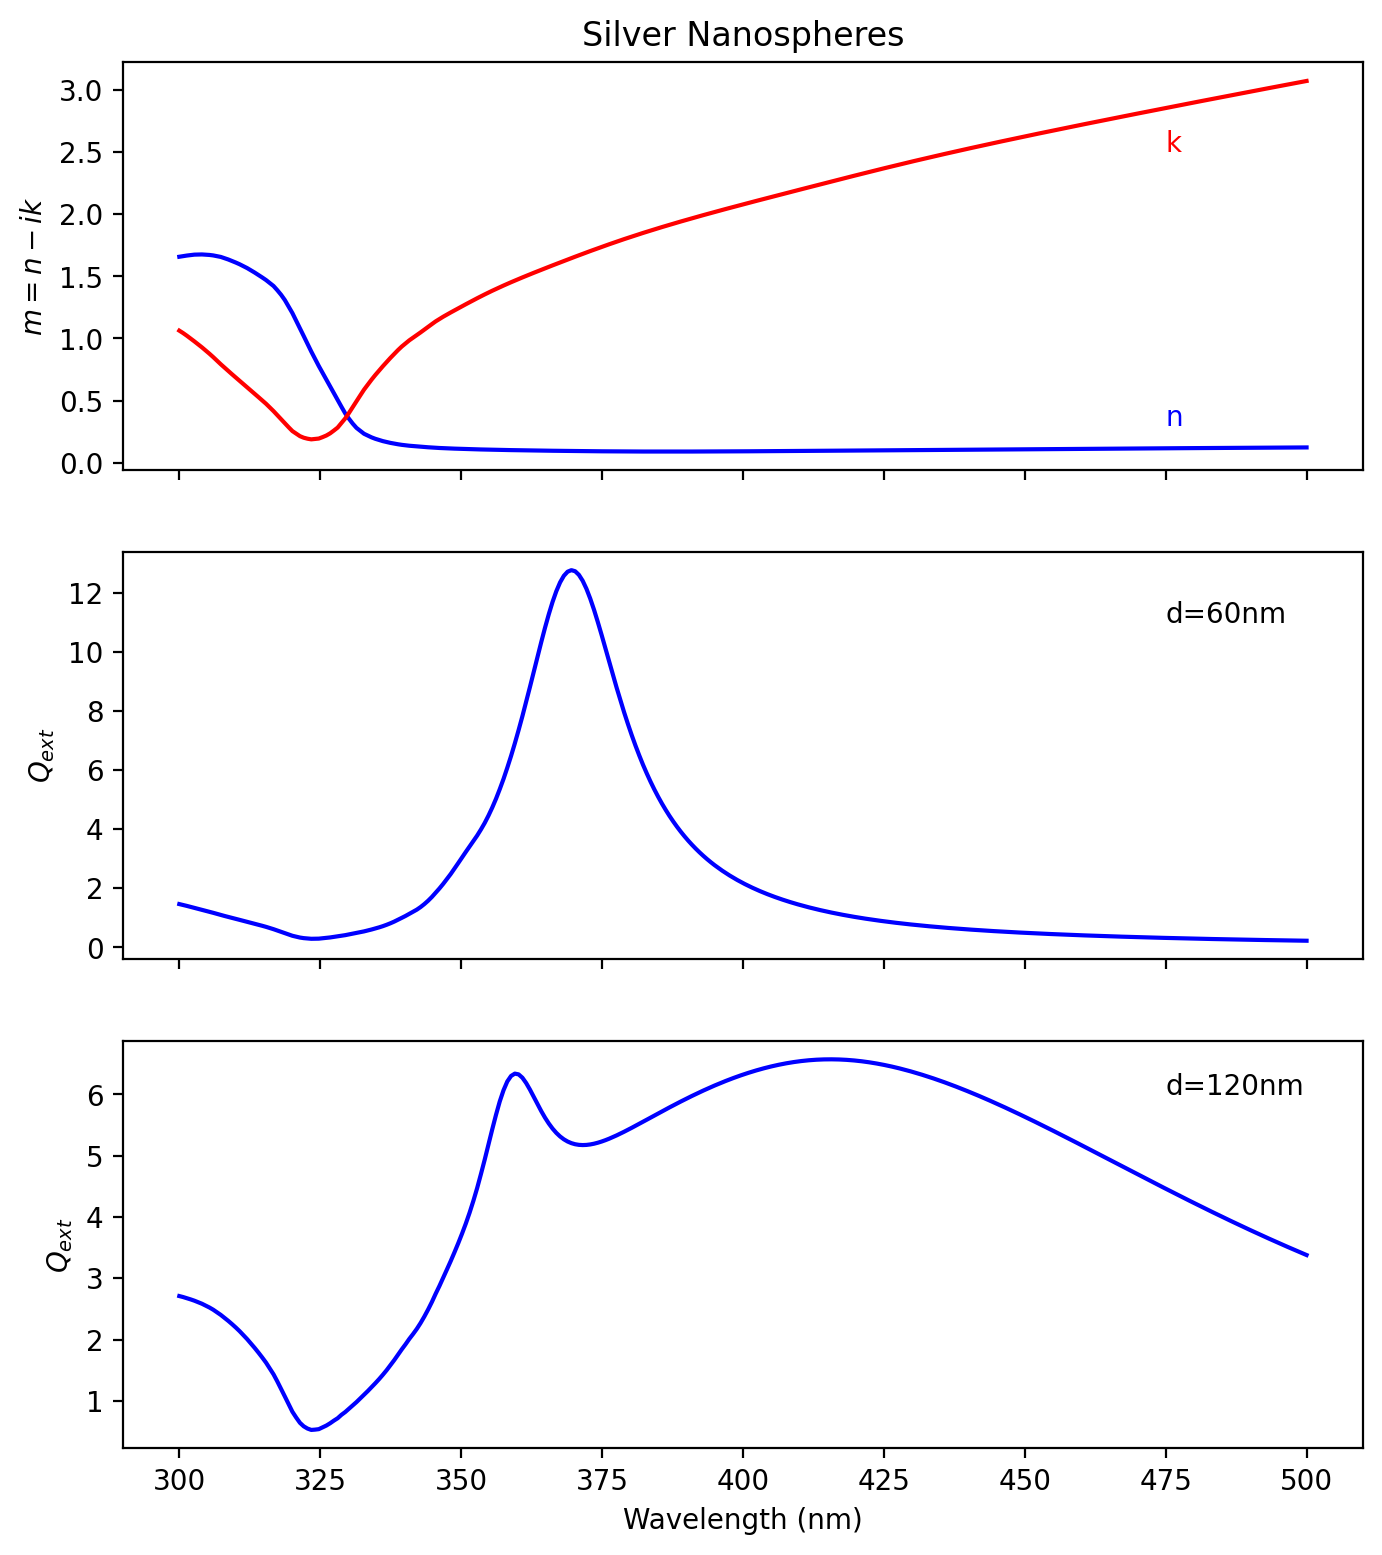

In [8]:
n_pole = 1
lam = np.linspace(0.3, 0.5, 300)
m = m_silver(lam)

plt.figure(figsize=(8, 9))

plt.subplot(3, 1, 1)
plt.plot(lam * 1000, m.real, "b", label="n")
plt.text(475, 0.3, "n", color="blue")
plt.plot(lam * 1000, m.imag, "r", label="k")
plt.text(475, 2.5, "k", color="red")
plt.ylabel("$m=n-ik$")
plt.gca().set_xticklabels([])
plt.title("Silver Nanospheres")

plt.subplot(3, 1, 2)
d = 0.060  # microns
x = np.pi * d / lam
qext, _, _, _ = mie.efficiencies_mx(m, x, 0)
plt.plot(lam * 1000, qext, "b", label="$a_%d$" % n_pole)
plt.ylabel("$Q_{ext}$")
plt.gca().set_xticklabels([])
plt.text(475, 11, "d=60nm")

plt.subplot(3, 1, 3)
d = 0.120  # microns
x = np.pi * d / lam
qext, _, _, _ = mie.efficiencies_mx(m, x, 0)
plt.plot(lam * 1000, qext, "b", label="$a_%d$" % n_pole)
plt.ylabel("$Q_{ext}$")
plt.text(475, 6, "d=120nm")
plt.xlabel("Wavelength (nm)")
plt.show()

### van de Hulst Figures 58 to 61

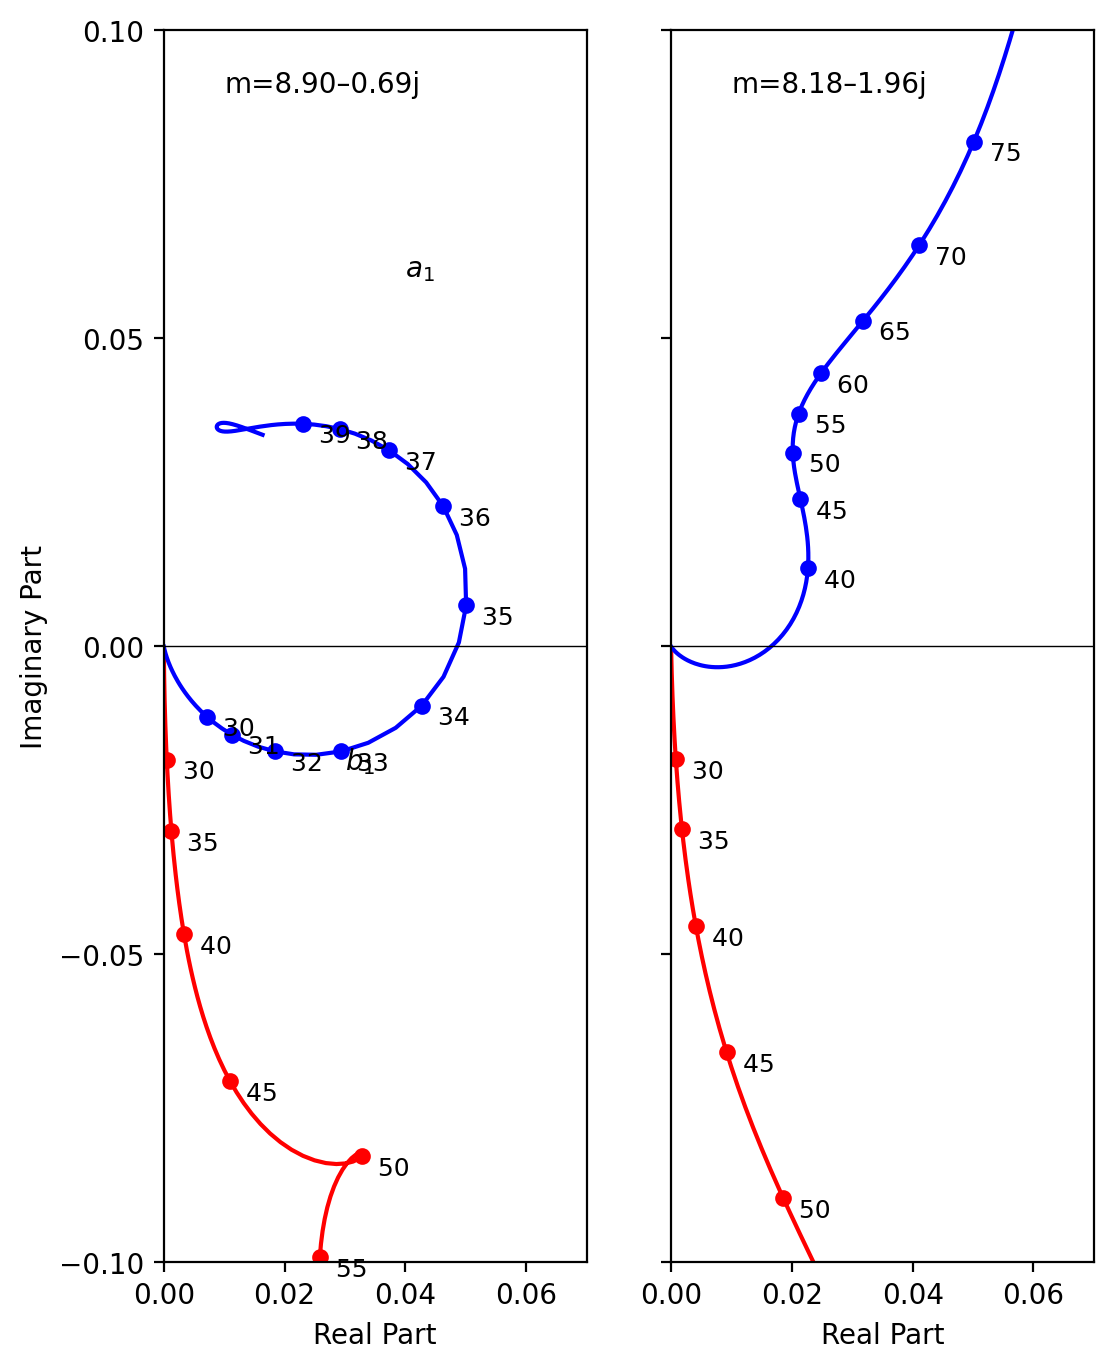

In [9]:
plt.subplots(1, 2, figsize=(6, 8))
plt.subplot(1, 2, 1)

m = 8.9 - 0.69j
x = np.linspace(0.10, 0.60, 151)
a1, b1 = mie.coefficients(m, x, 1)
plt.plot(a1.real, a1.imag, "r")
plt.plot(b1.real, b1.imag, "b")

x = np.linspace(0.30, 0.55, 6)
a1, b1 = mie.coefficients(m, x, 1)
plt.plot(a1.real, a1.imag, "ro", markersize=5)
for i, xx in enumerate(x):
    plt.text(a1.real[i], a1.imag[i], "  %d" % (int(100 * x[i])), ha="left", fontsize=9, va="top")

x = np.linspace(0.30, 0.39, 10)
a1, b1 = mie.coefficients(m, x, 1)
plt.plot(b1.real, b1.imag, "bo", markersize=5)
for i, xx in enumerate(x):
    plt.text(b1.real[i], b1.imag[i], "  %d" % (int(100 * x[i])), ha="left", fontsize=9, va="top")

plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.ylim(-0.1, 0.1)
plt.xlim(0, 0.07)
plt.yticks([-0.1, -0.05, 0, 0.05, 0.1])
plt.axhline(0, color="black", lw=0.5)
plt.text(0.01, 0.09, "m=8.90–0.69j")
plt.text(0.04, 0.06, r"$a_1$")
plt.text(0.03, -0.02, r"$b_1$")

plt.subplot(1, 2, 2)

m = 8.18 - 1.96j
x = np.linspace(0.10, 0.80, 200)
a1, b1 = mie.coefficients(m, x, 1)
plt.plot(a1.real, a1.imag, color="red")
plt.plot(b1.real, b1.imag, color="blue")

x = np.linspace(0.30, 0.50, 5)
a1, b1 = mie.coefficients(m, x, 1)
plt.plot(a1.real, a1.imag, "ro", markersize=5)
for i, xx in enumerate(x):
    plt.text(a1.real[i], a1.imag[i], "  %d" % (int(100 * x[i])), ha="left", fontsize=9, va="top")

x = np.linspace(0.40, 0.75, 8)
a1, b1 = mie.coefficients(m, x, 1)
plt.plot(b1.real, b1.imag, "bo", markersize=5)
for i, xx in enumerate(x):
    plt.text(b1.real[i], b1.imag[i], "  %d" % (int(100 * x[i])), ha="left", fontsize=9, va="top")

plt.gca().set_yticklabels([])
plt.ylim(-0.1, 0.1)
plt.xlim(0, 0.07)
plt.yticks([-0.1, -0.05, 0, 0.05, 0.1])
plt.axhline(0, color="black", lw=0.5)
plt.text(0.01, 0.09, "m=8.18–1.96j")
plt.xlabel("Real Part")

plt.show()

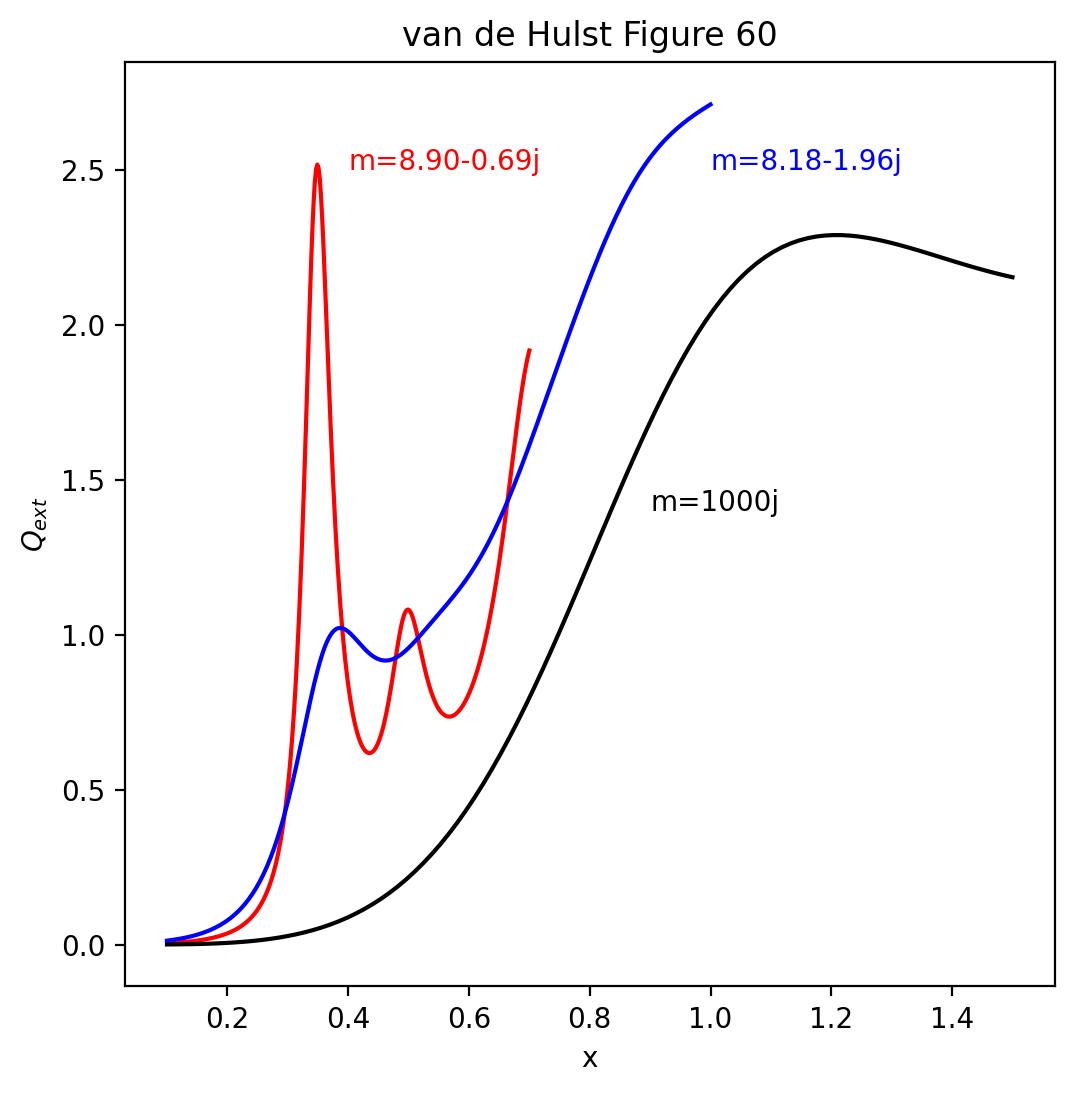

In [10]:
plt.figure(figsize=(6, 6))

m = 8.9 - 0.69j
x = np.linspace(0.1, 0.7, 300)
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
plt.plot(x, qext, "r")
plt.text(0.4, 2.5, "m=8.90-0.69j", ha="left", color="red")

m = 8.18 - 1.96j
x = np.linspace(0.1, 1.0, 300)
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
plt.plot(x, qext, "b")
plt.text(1.0, 2.5, "m=8.18-1.96j", ha="left", color="blue")

m = 1000j
x = np.linspace(0.1, 1.5, 100)
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
plt.text(0.9, 1.4, "m=1000j", ha="left", color="black")
plt.plot(x, qext, "k")
plt.xlabel("x")
plt.ylabel(r"$Q_{ext}$")
plt.title("van de Hulst Figure 60")
plt.show()

In [13]:
print(mie.__version__)

3.0.0


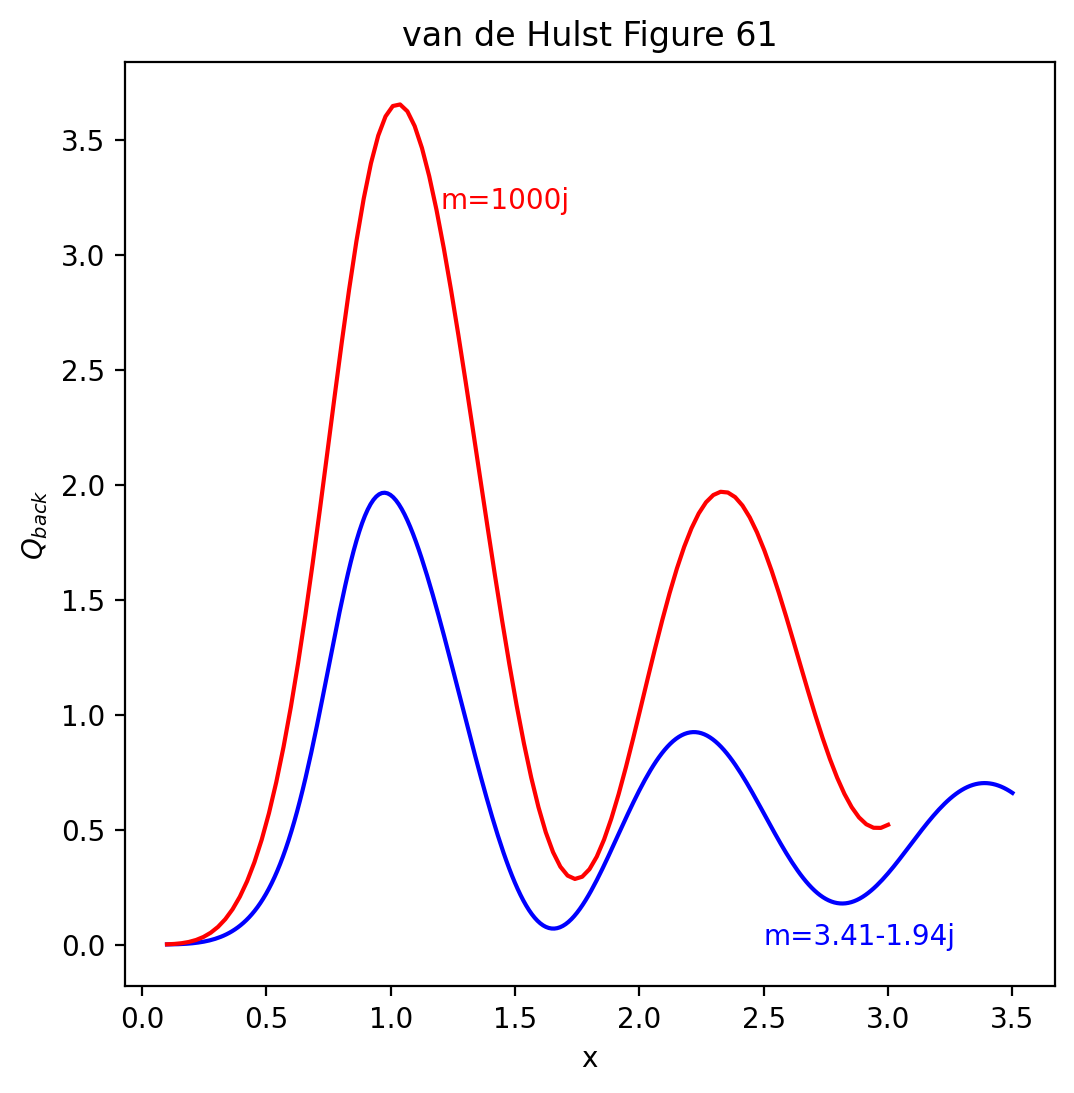

In [11]:
plt.figure(figsize=(6, 6))

m = 3.41 - 1.94j
x = np.linspace(0.1, 3.5, 300)
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
plt.plot(x, qback, "b")
plt.text(2.5, 0, "m=3.41-1.94j", ha="left", color="blue")

m = 1000j
x = np.linspace(0.1, 3, 100)
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
plt.text(1.2, 3.2, "m=1000j", ha="left", color="red")
plt.plot(x, qback, "r")
plt.xlabel("x")
plt.ylabel(r"$Q_{back}$")
plt.title("van de Hulst Figure 61")
plt.show()

### Refractive index of silicon

I was going to use this but never did.

In [12]:
#
# M. A. Green, Self-consistent optical parameters of intrinsic silicon at 300K including temperature coefficients.
# Sol. Energ. Mat. Sol. Cells, 92, 1305-1310 (2008)
#
silicon_lam, silicon_n, silicon_k = np.array(
    [
        [2.5000e-01, 1.6650e00, 3.6650e00],
        [2.6000e-01, 1.7570e00, 4.0840e00],
        [2.7000e-01, 2.0680e00, 4.6800e00],
        [2.8000e-01, 2.9590e00, 5.2870e00],
        [2.9000e-01, 4.3560e00, 5.2860e00],
        [3.0000e-01, 4.9760e00, 4.2340e00],
        [3.1000e-01, 5.1210e00, 3.5980e00],
        [3.2000e-01, 5.1120e00, 3.3030e00],
        [3.3000e-01, 5.1950e00, 3.1000e00],
        [3.4000e-01, 5.3010e00, 2.9770e00],
        [3.5000e-01, 5.4940e00, 2.9380e00],
        [3.6000e-01, 6.0260e00, 2.9660e00],
        [3.7000e-01, 6.8910e00, 2.1710e00],
        [3.8000e-01, 6.6160e00, 9.4600e-01],
        [3.9000e-01, 6.0390e00, 4.4500e-01],
        [4.0000e-01, 5.6130e00, 2.9600e-01],
        [4.1000e-01, 5.3300e00, 2.2700e-01],
        [4.2000e-01, 5.1190e00, 1.7600e-01],
        [4.3000e-01, 4.9490e00, 1.3800e-01],
        [4.4000e-01, 4.8120e00, 1.0700e-01],
        [4.5000e-01, 4.6910e00, 8.6302e-02],
        [4.6000e-01, 4.5870e00, 7.1381e-02],
        [4.7000e-01, 4.4970e00, 6.2086e-02],
        [4.8000e-01, 4.4190e00, 5.5004e-02],
        [4.9000e-01, 4.3500e00, 4.9131e-02],
        [5.0000e-01, 4.2940e00, 4.4165e-02],
        [5.1000e-01, 4.2410e00, 3.9367e-02],
        [5.2000e-01, 4.1930e00, 3.6415e-02],
        [5.3000e-01, 4.1510e00, 3.3108e-02],
        [5.4000e-01, 4.1120e00, 3.0295e-02],
        [5.5000e-01, 4.0770e00, 2.7968e-02],
        [5.6000e-01, 4.0450e00, 2.5758e-02],
        [5.7000e-01, 4.0150e00, 2.4131e-02],
        [5.8000e-01, 3.9880e00, 2.2524e-02],
        [5.9000e-01, 3.9630e00, 2.1081e-02],
        [6.0000e-01, 3.9400e00, 1.9934e-02],
        [6.1000e-01, 3.9180e00, 1.8446e-02],
        [6.2000e-01, 3.8980e00, 1.7367e-02],
        [6.3000e-01, 3.8790e00, 1.6444e-02],
        [6.4000e-01, 3.8610e00, 1.5432e-02],
        [6.5000e-01, 3.8440e00, 1.4431e-02],
        [6.6000e-01, 3.8280e00, 1.3498e-02],
        [6.7000e-01, 3.8130e00, 1.2743e-02],
        [6.8000e-01, 3.7980e00, 1.1905e-02],
        [6.9000e-01, 3.7840e00, 1.1201e-02],
        [7.0000e-01, 3.7720e00, 1.0528e-02],
        [7.1000e-01, 3.7590e00, 1.0057e-02],
        [7.2000e-01, 3.7480e00, 9.6257e-03],
        [7.3000e-01, 3.7370e00, 8.9461e-03],
        [7.4000e-01, 3.7270e00, 8.3620e-03],
        [7.5000e-01, 3.7170e00, 7.8185e-03],
        [7.6000e-01, 3.7080e00, 7.1970e-03],
        [7.7000e-01, 3.6990e00, 6.7402e-03],
        [7.8000e-01, 3.6910e00, 6.3933e-03],
        [7.9000e-01, 3.6830e00, 5.8340e-03],
        [8.0000e-01, 3.6750e00, 5.4113e-03],
        [8.1000e-01, 3.6680e00, 4.9955e-03],
        [8.2000e-01, 3.6610e00, 4.6134e-03],
        [8.3000e-01, 3.6540e00, 4.2734e-03],
        [8.4000e-01, 3.6470e00, 3.9439e-03],
        [8.5000e-01, 3.6410e00, 3.6120e-03],
        [8.6000e-01, 3.6350e00, 3.2781e-03],
        [8.7000e-01, 3.6300e00, 2.9839e-03],
        [8.8000e-01, 3.6240e00, 2.6821e-03],
        [8.9000e-01, 3.6190e00, 2.4293e-03],
        [9.0000e-01, 3.6140e00, 2.1701e-03],
        [9.1000e-01, 3.6090e00, 1.9625e-03],
        [9.2000e-01, 3.6040e00, 1.7571e-03],
        [9.3000e-01, 3.6000e00, 1.5467e-03],
        [9.4000e-01, 3.5950e00, 1.3689e-03],
        [9.5000e-01, 3.5910e00, 1.1793e-03],
        [9.6000e-01, 3.5870e00, 1.0237e-03],
        [9.7000e-01, 3.5830e00, 8.7225e-04],
        [9.8000e-01, 3.5790e00, 7.4866e-04],
        [9.9000e-01, 3.5750e00, 6.2238e-04],
        [1.0000e00, 3.5720e00, 5.0930e-04],
        [1.0100e00, 3.5680e00, 4.1071e-04],
        [1.0200e00, 3.5650e00, 3.2386e-04],
        [1.0300e00, 3.5620e00, 2.4753e-04],
        [1.0400e00, 3.5590e00, 1.8704e-04],
        [1.0500e00, 3.5560e00, 1.3620e-04],
        [1.0600e00, 3.5530e00, 9.3631e-05],
        [1.0700e00, 3.5500e00, 6.8118e-05],
        [1.0800e00, 3.5470e00, 5.3285e-05],
        [1.0900e00, 3.5450e00, 4.0768e-05],
        [1.1000e00, 3.5420e00, 3.0637e-05],
        [1.1100e00, 3.5400e00, 2.3849e-05],
        [1.1200e00, 3.5370e00, 1.7825e-05],
        [1.1300e00, 3.5350e00, 1.3488e-05],
        [1.1400e00, 3.5320e00, 9.0718e-06],
        [1.1500e00, 3.5300e00, 6.2230e-06],
        [1.1600e00, 3.5280e00, 3.8770e-06],
        [1.1700e00, 3.5260e00, 2.0483e-06],
        [1.1800e00, 3.5240e00, 6.1036e-07],
        [1.1900e00, 3.5220e00, 3.4091e-07],
        [1.2000e00, 3.5200e00, 2.1008e-07],
        [1.2100e00, 3.5180e00, 1.2518e-07],
        [1.2200e00, 3.5170e00, 7.9609e-08],
        [1.2300e00, 3.5150e00, 4.6004e-08],
        [1.2400e00, 3.5130e00, 2.3682e-08],
        [1.2500e00, 3.5110e00, 9.9472e-09],
        [1.2600e00, 3.5090e00, 3.6096e-09],
        [1.2700e00, 3.5080e00, 2.0213e-09],
        [1.2800e00, 3.5060e00, 1.2223e-09],
        [1.2900e00, 3.5050e00, 7.2885e-10],
        [1.3000e00, 3.5030e00, 4.6553e-10],
        [1.3100e00, 3.5020e00, 2.8147e-10],
        [1.3200e00, 3.5000e00, 1.6807e-10],
        [1.3300e00, 3.4990e00, 8.4670e-11],
        [1.3400e00, 3.4970e00, 3.7322e-11],
        [1.3500e00, 3.4960e00, 1.8263e-11],
        [1.3600e00, 3.4950e00, 1.0281e-11],
        [1.3700e00, 3.4940e00, 6.5413e-12],
        [1.3800e00, 3.4920e00, 4.1730e-12],
        [1.3900e00, 3.4910e00, 2.5441e-12],
        [1.4000e00, 3.4900e00, 1.5597e-12],
        [1.4100e00, 3.4890e00, 9.5374e-13],
        [1.4200e00, 3.4880e00, 5.6500e-13],
        [1.4300e00, 3.4870e00, 2.8449e-13],
        [1.4400e00, 3.4860e00, 2.0626e-13],
        [1.4500e00, 3.4850e00, 1.3846e-13],
    ]
).T


def m_silicon(lambda_microns):
    """
    Computes the complex refractive index of silicon for given wavelengths.

    The refractive index m = n - i k is interpolated from tabulated data
    of the real n and imaginary k parts of the refractive index
    over a range of wavelengths.

    Args:
        lambda_microns (float or array-like):
            Wavelength(s) in microns at which to compute the refractive index.
            Values must be within the range [0.25, 1.45].

    Returns:
        complex or numpy.ndarray:
            Complex refractive index m = n - i k, where:
            - n: Real part of the refractive index (phase velocity).
            - k: Imaginary part of the refractive index (absorption).
    """
    lambda_microns = np.asarray(lambda_microns)

    # Check if all input values are within the valid range
    if not np.all((0.25 <= lambda_microns) & (lambda_microns <= 1.45)):
        raise ValueError("All values in lambda_microns must be within the range 0.25-1.45 microns. ")

    n = np.interp(lambda_microns, silicon_lam, silicon_n)
    k = np.interp(lambda_microns, silicon_lam, silicon_k)

    return n - 1j * k